## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

2\. Find out the value of 'x'

3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

6\. Create a new DataFrame with only the raws with HEAD=1

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#file_name="/home/spiro/home/polatoc/data/data_000637.txt"
file_name="C:/Users/CP/data/data_000637.txt"
data=pd.read_csv(file_name)
data.shape

(1310720, 6)

# EX 1

In [3]:
data=pd.read_csv(file_name,nrows=20000,skiprows=range(1,1)) #skiprows=range(1,1) doesn't skip anything
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
5,1,0,63,3869200167,2762,4
6,1,0,61,3869200167,2772,14
7,1,0,139,3869200167,2776,0
8,1,0,62,3869200167,2774,21
9,1,0,60,3869200167,2788,7


In [4]:
data=pd.read_csv(file_name,nrows=1310720,skiprows=range(1,1)) #load all the file

# EX 2

In [5]:
data.describe()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
count,1310720.0,1.310720e+06,1.310720e+06,1.310720e+06,1.310720e+06,1.310720e+06
mean,1.0,2.959198e-01,5.582570e+01,3.869206e+09,1.781096e+03,1.332340e+01
std,0.0,4.564553e-01,3.901034e+01,3.183124e+03,1.027795e+03,9.199886e+00
min,1.0,0.000000e+00,1.000000e+00,3.869200e+09,0.000000e+00,0.000000e+00
25%,1.0,0.000000e+00,2.600000e+01,3.869203e+09,8.930000e+02,5.000000e+00
50%,1.0,0.000000e+00,5.700000e+01,3.869207e+09,1.778000e+03,1.300000e+01
75%,1.0,1.000000e+00,6.400000e+01,3.869209e+09,2.670000e+03,2.100000e+01
max,1.0,1.000000e+00,1.390000e+02,3.869211e+09,3.563000e+03,2.900000e+01


In [6]:
print("PER BX_COUNTER il minimo e':",data['BX_COUNTER'].min(),"e il massimo e':",data['BX_COUNTER'].max())

PER BX_COUNTER il minimo e': 0 e il massimo e': 3563


In [7]:
print("PER TDC_MEAS il minimo e':",data['TDC_MEAS'].min(),"e il massimo e':",data['TDC_MEAS'].max())

PER TDC_MEAS il minimo e': 0 e il massimo e': 29


# EX 3

# IT'S NOT MONOTONIC SO WE SHOULD LOOK FOR MAX AND MIN

In [8]:
zeroth_correction=(data['ORBIT_CNT'].max()-data['ORBIT_CNT'].min())*data['BX_COUNTER'].max()*25e-9
first_correction=(data['BX_COUNTER'].iloc[-1]-data['BX_COUNTER'].iloc[0])*25e-9
second_correction=(data['TDC_MEAS'].iloc[-1]-data['TDC_MEAS'].iloc[0])*25e-9/data['TDC_MEAS'].max()
print(zeroth_correction,first_correction,second_correction)
print("The acquisition lasted:",zeroth_correction+first_correction+second_correction)

0.9801812999999999 -4.03e-05 -6.896551724137931e-09
The acquisition lasted: 0.9801409931034482


# EX 4

# IT'S NOT MONOTONIC SO WE SHOULD LOOK FOR MAX AND MIN

In [9]:
data['TIME (s)'] = data['ORBIT_CNT']*data['BX_COUNTER'].max()*25e-9-data['ORBIT_CNT'][0]*data['BX_COUNTER'].max()*25e-9
data['TIME (s)'] += data['BX_COUNTER']*25e-9-data['BX_COUNTER'].iloc[0]*25e-9
data['TIME (s)'] += data['TDC_MEAS']*25e-9/data['TDC_MEAS'].max()-data['TDC_MEAS'].iloc[0]*25e-9/data['TDC_MEAS'].max()
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (s)
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.620690e-10
2,1,0,63,3869200167,2553,28,4.476724e-06
3,1,0,64,3869200167,2558,19,4.593966e-06
4,1,0,64,3869200167,2760,25,9.649138e-06
5,1,0,63,3869200167,2762,4,9.681034e-06
6,1,0,61,3869200167,2772,14,9.939655e-06
7,1,0,139,3869200167,2776,0,1.002759e-05
8,1,0,62,3869200167,2774,21,9.995690e-06
9,1,0,60,3869200167,2788,7,1.033362e-05


# EX 5

In [10]:
data1=data.copy()
data1['HEAD']=np.random.randint(0, high=2, size=data.shape[0])
data1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (s)
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.620690e-10
2,0,0,63,3869200167,2553,28,4.476724e-06
3,0,0,64,3869200167,2558,19,4.593966e-06
4,0,0,64,3869200167,2760,25,9.649138e-06
5,1,0,63,3869200167,2762,4,9.681034e-06
6,0,0,61,3869200167,2772,14,9.939655e-06
7,1,0,139,3869200167,2776,0,1.002759e-05
8,1,0,62,3869200167,2774,21,9.995690e-06
9,1,0,60,3869200167,2788,7,1.033362e-05


# EX 6

In [11]:
data2=data1[data1['HEAD'] > 0]
data2

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (s)
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.620690e-10
5,1,0,63,3869200167,2762,4,9.681034e-06
7,1,0,139,3869200167,2776,0,1.002759e-05
8,1,0,62,3869200167,2774,21,9.995690e-06
9,1,0,60,3869200167,2788,7,1.033362e-05
10,1,1,7,3869200167,2785,4,1.025603e-05
11,1,0,64,3869200167,2786,19,1.029397e-05
13,1,0,36,3869200167,2791,23,1.042241e-05
14,1,0,56,3869200167,2789,3,1.035517e-05


# EX 7

# FORGET ABOUT RANDOM HEAD AND DIVIDE BY FPGA

In [12]:
dataFPGA0=data[data['FPGA']>0]
dataFPGA1=data[data['FPGA']<1]
dataFPGA0

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (s)
10,1,1,7,3869200167,2785,4,0.000010
12,1,1,6,3869200167,2792,18,0.000010
15,1,1,139,3869200167,2797,0,0.000011
16,1,1,8,3869200167,2787,14,0.000010
18,1,1,5,3869200167,2795,4,0.000011
20,1,1,10,3869200167,2789,14,0.000010
43,1,1,1,3869200168,7,18,0.000030
45,1,1,1,3869200168,13,18,0.000030
47,1,1,2,3869200168,17,26,0.000030
54,1,1,61,3869200168,260,16,0.000036


In [13]:
dataFPGA1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME (s)
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.620690e-10
2,1,0,63,3869200167,2553,28,4.476724e-06
3,1,0,64,3869200167,2558,19,4.593966e-06
4,1,0,64,3869200167,2760,25,9.649138e-06
5,1,0,63,3869200167,2762,4,9.681034e-06
6,1,0,61,3869200167,2772,14,9.939655e-06
7,1,0,139,3869200167,2776,0,1.002759e-05
8,1,0,62,3869200167,2774,21,9.995690e-06
9,1,0,60,3869200167,2788,7,1.033362e-05


# SPLITTING IS USELESS IF WE USE GROUPBY

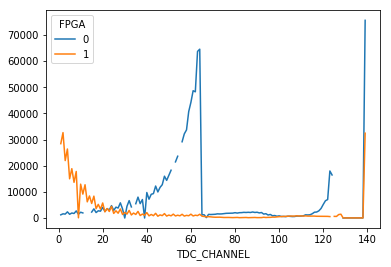

In [14]:
data_group=data.groupby(['FPGA','TDC_CHANNEL']).sum()#groupby().sum() basically sum on the samples with same FPGA and TDC_CHANNEL
#data_group.plot() #CAN'T PLOT IMMEDIATLY OTHERWISE WE SHOW ALL THE INSTANCES
#data_group['HEAD'].plot() #WITH THIS I WOULD PLOT THE SIGNALS FROM 2 FPGA SUPERIMPOSED
data_group.unstack('FPGA')['HEAD'].plot() # HEAD IS THE IMPORTANT THING TO SHOW SINCE IS 1 FOR EVERY COUNT
                                          # unstack('FPGA') IS IMPORTANT TO SPLIT THE SIGNALS FROM THE 2 FPGA
plt.show()

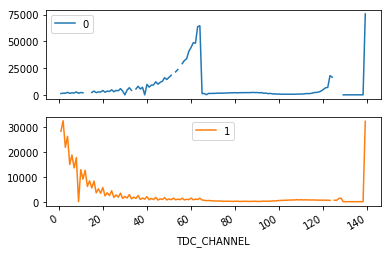

In [15]:
data_group=data.groupby(['FPGA','TDC_CHANNEL']).sum()
data_group.unstack('FPGA')['HEAD'].plot(subplots=True)
plt.show()

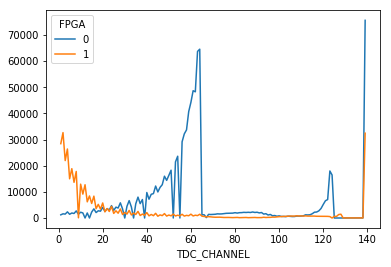

In [16]:
data_group=data.groupby(['FPGA','TDC_CHANNEL']).sum()
data_group.unstack('FPGA')['HEAD'].fillna(value=0).plot() #FILLNA PUTS 0 INSTEAD OF ALL NAN
plt.show()

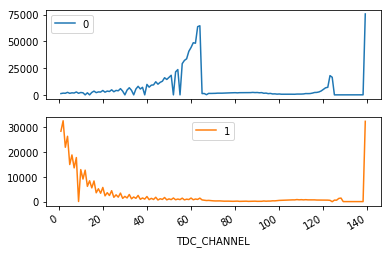

In [17]:
data_group=data.groupby(['FPGA','TDC_CHANNEL']).sum()
data_group.unstack('FPGA')['HEAD'].fillna(value=0).plot(subplots=True) #FILLNA PUTS 0 INSTEAD OF ALL NAN
plt.show()

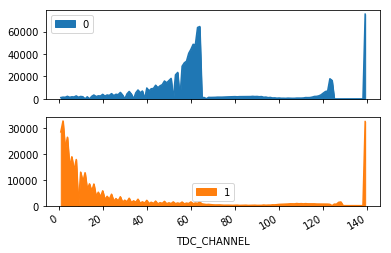

In [31]:
data_group=data.groupby(['FPGA','TDC_CHANNEL']).sum()
data_group.unstack('FPGA')['HEAD'].fillna(value=0).plot(kind = 'area', subplots=True) #FILLNA PUTS 0 INSTEAD OF ALL NAN
plt.show()

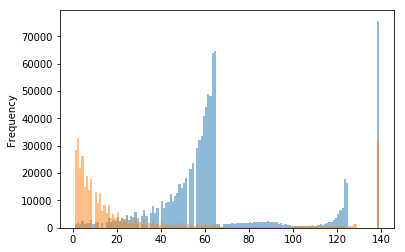

In [18]:
#using histograms
g = data.groupby(['FPGA'])
n_bins = data.TDC_CHANNEL.max()-data.TDC_CHANNEL.min() # COUNTS NUMBER IF TDC_CHANNEL TO KNOW HOW MANY BINS TO USE
g.TDC_CHANNEL.plot(kind = 'hist', bins = n_bins, alpha = 0.5) #alpha=0. -> transparent alpha=1. -> opaque
plt.show()

# EX 8

In [19]:
peaks = data.groupby(['FPGA','TDC_CHANNEL']).sum() # SAME TRICK AS IN EX 7

num_peaks = 3

result = pd.DataFrame([peaks['HEAD'].nlargest(num_peaks).index])#WE WANT THE INDEX(TDC_CHANNEL) OF THE PEAKS NOT THE VALUE ITSELF

result.rename({0: '(FPGA, TDC_CHAN)'},columns=lambda x: x+1) #TO RENAME ROWS YOU MUST STATE PREVIOUS->0 AND NEW->(FPGA, TDC_CHAN)
                                                             #TO SHIFT COLUMN FROM 0,1,2 TO 1,2,3 WE USE A LAMBDA FUNCTION

,1,2,3
"(FPGA, TDC_CHAN)","(0, 139)","(0, 64)","(0, 63)"


In [20]:
#number of 'most noisy' channels
num_noise = 3

#given the number n, it gives back the associated ordinal; for example, ordinal(5) = 5th
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4]) 

#dictionaries for future use in renaming rows and columns of the final dataframe
index_c = {0: 'FPGA', 1:'TDC_CHANNEL'}
index_r = {i: ordinal(i+1) for i in range(num_noise)}

#grouped data
datanoise = data.groupby(['FPGA','TDC_CHANNEL']).sum()

#list of the three couples (fpga, channel)
noisy = [pd.DataFrame([datanoise['HEAD'].nlargest(num_noise).index]).T.unstack().iloc[i] for i in range(num_noise)]

#separation of the couples and creation of a nicer dataframe
noisy = pd.DataFrame(noisy).rename(index = index_r, columns = index_c)
noisy

,FPGA,TDC_CHANNEL
1st,0,139
2nd,0,64
3rd,0,63


# EX 9

In [30]:
#grouping by orbit count

num_orb = data.groupby('ORBIT_CNT').sum()['HEAD'] #TAKES ONLY HEAD (WHICH COUNTS) GROUPING BY 'ORBIT_CNT'

#in the next lines we calculate the number of orbits which appear only once in the database

un_orb = num_orb[num_orb == 1] #FILTER THE COLUMN DATAFRAME TAKING ONLY THE UNIQUE ONE 
print('Number of unique orbits: ', un_orb.sum())

for i in range(un_orb.sum()):
    print("unique orbit count",i+1,":",un_orb.index[i])

#in the next lines we calculate the number of distinct orbits

dist_orb = num_orb.count() #AFTER GROUPING PER ORBIT_COUNT WE COUNT THE NUMBER OF DIFFERENT GROUPS (i.e. ORBITS)
print('Number of distinct orbits: ',dist_orb) 

#counts from 139
data_139 = data[data['TDC_CHANNEL'] == 139].groupby('ORBIT_CNT').sum()['HEAD'] #BEFORE DOING THE SAME AD BEFORE WE FILTER TDC=139
dist_orb_139 = data_139.count()
print('Number of distinct orbits having at least one count from TDC_CHANNEL 139: ',dist_orb_139)

Number of unique orbits:  2
unique orbit count 1 : 3869204142
unique orbit count 2 : 3869206180
Number of distinct orbits:  11001
Number of distinct orbits having at least one count from TDC_CHANNEL 139:  10976
